# **Trabalho 1** Aprendizado de Máquina

### **Parte teórica**

Um problema multiclasse é uma generalização do problema binário. Podemos olhar para classificadores multiclasse como diversos classificadores binários, ou seja, classificam se possuem determinada característica ou se não possuem diversas vezes.

Os classificadores gaussianos e SVM podem lidar naturalmente com problemas multiclasse, logo poderíamos utilizá-los diretamente neste tipo de problema. 

Porém, existem técnicas melhores para lidar com problemas multiclasse, que é olharmos para eles como problemas de várias decisões binárias. Os métodos OvO (um contra um) e OvR (um contra todos) funcionam dessa maneira.

No OvO testamos todas as possibilidades 2 a 2 das classes do problema, ao final classificamos com a classe que mais ganhou nesses duelos, porém é um método com alguns problemas, como as decisões entre duas classes que são erradas, podendo distorcer o resultado.

Já no OvR compara-se cada classe ao restante, decidindo se é ou não é daquela classe, e não mais se decide entre duas classes, o que faz mais sentido, já que agora para todas essas decisões teremos uma delas correta: pertence ou não pertence à classe. Ao final, classificamos com a classe de maior probabilidade nos testes.

Nesse tipo de problema usar a acurácia é útil para medirmos a taxa de acerto nas classificações. Outras métricas, como a ROC ou F1, podemos observar individualmente para cada classe e medir o desempenho do classificador para cada uma delas.

### **Parte prática**

Analisar uma base de dados que contém imagens de satélite da superfície de Vênus. Primeiro, iremos detectar a presença de vulcões nas imagens, e depois classificá-los em diferentes tipos.

### Importação das biliotecas

Serão necessárias algumas biliotecas como
- Numpy e Pandas para manipular os dados
- Matplotlib e Seaborn para plotar gráficos e as imagens
- SciKit Image para fazer os processamentos das imagens
- SciKit Learn para treinar e testar os modelos nos dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.exposure import rescale_intensity
from skimage.morphology import reconstruction
from skimage.restoration import denoise_tv_chambolle
from skimage.feature import hog

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, make_scorer, classification_report, plot_confusion_matrix

### Importação dos dados do Google Drive

Aqui vamos importar os dados do Google Drive para utilizá-los no Google Colab.

In [2]:
# Instalando PyDrive para importar os dados do Google Drive
!pip install -U -q PyDrive

In [3]:
# Importando PyDrive e fazendo autenticação do Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id_train_images = '1Fu5LsAcWeH72-P2TILSux0LN7SRZ4RDr'
id_train_labels = '1aafaFxxp6Us10G7LJ9UQXrjpM6MvX0c2'
id_test_images = '1LTz7-EdCXgiL2lCUxFZ8WDFmdQyRKdTf'
id_test_labels = '1IaWthtL5tQRV0h3TuiLoY5sIlgDtDntW'

In [4]:
# Download do conjunto das imagens de treinamento
downloaded = drive.CreateFile({'id':id_train_images}) 
downloaded.GetContentFile('train_images.csv')
X_train = pd.read_csv('train_images.csv', header = None)

In [5]:
# Download do conjunto das repsostas de treinamento
downloaded = drive.CreateFile({'id':id_train_labels}) 
downloaded.GetContentFile('train_labels.csv')
y_train = pd.read_csv('train_labels.csv')

In [6]:
# Download do conjunto das imagens de teste
downloaded = drive.CreateFile({'id':id_test_images}) 
downloaded.GetContentFile('test_images.csv')
X_test = pd.read_csv('test_images.csv', header = None)

In [7]:
# Download do conjunto das respostas de teste
downloaded = drive.CreateFile({'id':id_test_labels}) 
downloaded.GetContentFile('test_labels.csv')
y_test = pd.read_csv('test_labels.csv')

### Definindo os classificadores

Agora atribuímos a variáveis os classificadores do SciKit Learn que usaremos para comparação e treinamento dos dados.

**Classificadores gaussianos**
- NB: Naive Bayes
- LDA: Linear Discriminant Analysis
- QDA: Quadratic Discriminant Analysis

**Classificadores SVM**
- SVC_lin:  Support Vector Classification com kernel linear
- SVC_poly:  Support Vector Classification com kernel polinomial
- SVC_rbf:  Support Vector Classification com kernel RBF

In [8]:
# Definindo os classificadores gaussianos
NB = GaussianNB()
LDA = LinearDiscriminantAnalysis()
QDA = QuadraticDiscriminantAnalysis()

# Definindo o classificadores SVM
SVC_lin = SVC(kernel='linear')
SVC_poly = SVC(kernel='poly')
SVC_rbf = SVC(kernel='rbf')

### Observando os dados

Plotamos o início do DataFrame e vemos as características dos dados.
- Cada valor é um pixel de uma imagem 110x110, totalizando 12100 pixels
- Os valores estão entre 0 e 255
- O valor representa a intensidade da cor no pixel, sendo a imagem monocromática

In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12060,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,95,101,99,103,95,86,96,89,70,104,115,96,89,102,109,108,102,104,95,91,100,99,97,100,107,109,98,98,94,98,102,87,82,94,105,93,102,107,98,105,...,101,95,105,103,74,88,106,111,90,96,101,90,97,102,97,106,108,107,93,74,106,115,107,102,91,103,111,105,116,117,111,107,92,89,103,99,117,116,118,96
1,91,92,91,89,92,93,96,101,107,104,92,81,76,83,88,93,91,92,93,90,83,81,79,84,86,87,92,93,94,94,87,83,95,96,94,91,93,96,93,87,...,95,91,91,89,88,90,88,93,95,106,113,116,108,94,92,96,99,92,87,89,105,119,121,116,111,113,112,103,101,103,103,92,93,95,98,105,104,100,90,81
2,87,70,72,74,84,78,93,104,106,106,94,79,96,88,86,89,98,94,76,78,91,96,86,71,82,76,72,81,90,84,81,70,75,91,81,81,92,94,79,97,...,86,80,83,93,94,91,90,94,96,78,88,95,121,108,88,87,89,100,99,88,107,108,101,88,95,81,57,84,89,92,84,71,95,102,94,80,91,80,84,90
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,101,114,104,103,81,94,108,96,79,113,113,114,112,107,110,112,98,76,84,97,99,95,68,97,91,97,96,83,100,106,94,81,89,84,80,90,92,80,88,96
4,114,118,124,119,95,118,105,116,123,112,110,113,119,112,105,121,117,125,136,141,120,120,129,135,132,124,109,126,113,110,106,107,113,116,123,101,99,89,81,101,...,105,116,114,103,114,109,113,126,110,84,92,111,114,125,122,109,113,111,121,119,103,114,118,118,108,111,109,100,101,105,116,113,102,93,109,104,106,117,111,115


Plotamos as primeiras 8 imagens em preto (0) e branco (255)
- Percebe-se que as imagens possuem bastante ruídos, os quais dificultam a identificação dos vulcões
- Um pré-processamento nas imagens, intensificando as cores das imagens, destacando as manchas do vulcão e removendo os ruídos

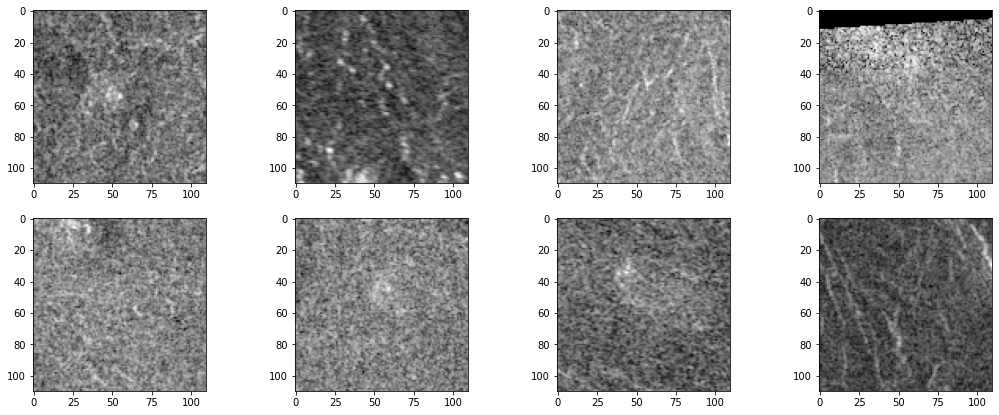

In [ ]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(18, 7)
ind = 0

for ax in axs.flat:
    img = np.array(X_train.iloc[ind]).reshape((110,110))
    ax.imshow(img, cmap = 'gray')
    ind += 1

In [ ]:
y_train.iloc[:8]

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN
5,0,NaN,NaN,NaN
6,0,NaN,NaN,NaN
7,0,NaN,NaN,NaN


## Problema da detecção de vulcão

### Intensificando as cores e destacando os picos

Aqui começamos o pré-processamento das imagens.
- Criamos um novo conjunto com as imagens processadas
- Intensificamos as cores, o contraste das partes mais claras com as mais escuras ficam mais evidentes
- Destacamos as manchas dos picos para facilitar a identificação dos vulcões

In [9]:
# Copiando as imagens originais para uma nova variável
X_peaks = np.array(X_train) 
ind = 0

# Tratando as imagens uma a uma e substituindo no array inicial
for image in X_peaks:
    image = image.reshape((110,110))
    image = rescale_intensity(image, in_range=(80, 300)) # Intensifica as cores, aumentando o contraste
    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    rec = reconstruction(seed, image, method='dilation') # Destaca os picos
    img = image-rec
    X_peaks[ind] = img.reshape((12100,)) # Adiciona a nova imagem ao conjunto
    ind += 1

# Copiando as imagens originais para uma nova variável
X_peaks_test = np.array(X_test)
ind = 0

# Tratando as imagens uma a uma e substituindo no array inicial
for image in X_peaks_test:
    image = image.reshape((110,110))
    image = rescale_intensity(image, in_range=(80, 300)) # Intensifica as cores, aumentando o contraste
    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    rec = reconstruction(seed, image, method='dilation') # Destaca os picos
    img = image-rec
    X_peaks_test[ind] = img.reshape((12100,)) # Adiciona a nova imagem ao conjunto
    ind += 1

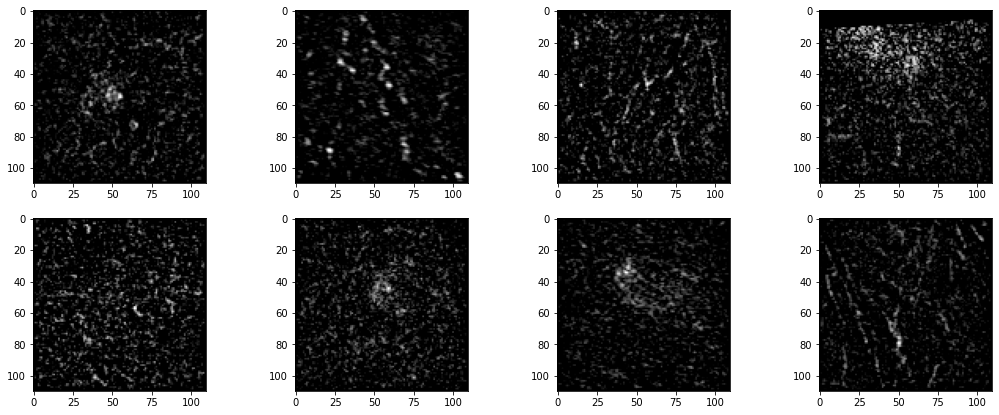

In [11]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(18, 7)
ind = 0

for ax in axs.flat:
    img = np.array(X_peaks[ind]).reshape((110,110))
    ax.imshow(img, cmap = 'gray')
    ind += 1

### Comparando os classificadores gaussianos no novo conjunto

Começamos aqui as testes dos modelos gaussianos que são mais rápidos para fazer uma validação cruzada para comparação.
- Vamos treinar o modelo para classificar se a imagem possui ou não um vulcão
- Fazemos a validação cruzada em cada classificador, com 5 dobras
- Fazemos a média das métricas F1 e ROC para testar o desempenho de cada um dos classificadores
- Ao todo, foram 10 (5 por métrica) treinos para cada classificador

In [ ]:
# Validação cruzada no classificador Naive Bayes com a métrica ROC
peaks_NB_roc = cross_val_score(NB, X_peaks, y_train['Volcano?'], cv = 5,
                scoring = make_scorer(roc_auc_score, greater_is_better = True, needs_proba = True)).mean()

# Validação cruzada no classificador LDA com a métrica ROC
peaks_LDA_roc = cross_val_score(LDA, X_peaks, y_train['Volcano?'], cv = 5,
                scoring = make_scorer(roc_auc_score, greater_is_better = True, needs_proba = True)).mean()

# Validação cruzada no classificador QDA com a métrica ROC
peaks_QDA_roc = cross_val_score(QDA, X_peaks, y_train['Volcano?'], cv = 5,
                scoring = make_scorer(roc_auc_score, greater_is_better = True, needs_proba = True)).mean()

In [ ]:
# Validação cruzada no classificador Naive Bayes com a métrica F1
peaks_NB_f1 = cross_val_score(NB, X_peaks, y_train['Volcano?'], cv = 5,
                scoring = make_scorer(f1_score, greater_is_better = True, needs_proba = False)).mean()

# Validação cruzada no classificador LDA com a métrica F1
peaks_LDA_f1 = cross_val_score(LDA, X_peaks, y_train['Volcano?'], cv = 5,
                scoring = make_scorer(f1_score, greater_is_better = True, needs_proba = False)).mean()

# Validação cruzada no classificador QDA com a métrica F1
peaks_QDA_f1 = cross_val_score(QDA, X_peaks, y_train['Volcano?'], cv = 5,
                scoring = make_scorer(f1_score, greater_is_better = True, needs_proba = False)).mean()

In [ ]:
print(f"CV nos classificadores gaussianos (peaks)\n\nNB: roc {peaks_NB_roc} f1 {peaks_NB_f1}\nLDA: roc {peaks_LDA_roc} f1 {peaks_LDA_f1}\nQDA: roc {peaks_QDA_roc} f1 {peaks_QDA_f1}")

### Resultados do CV nos classificadores gaussianos (usando os picos)

Obtivemos os seguintes resultados para as métricas

- NB: roc 0.90 f1 0.67
- LDA: roc 0.92 f1 0.73
- QDA: roc 0.74 f1 0.39

Vemos que o classificador LDA é o melhor dentre os gaussianos com a métrica ROC de 0.92 e F1 de 0.73. Assim, ele será um candidato ao final para a decisão do melhor classificador para o nosso problema.

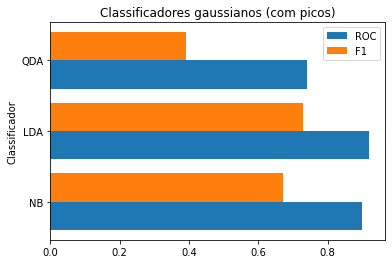

In [ ]:
labels = ['NB','LDA','QDA']
roc = [0.90,0.92,0.74]
f1 = [0.67,0.73,0.39]

X_axis = np.arange(len(X))
  
plt.barh(X_axis - 0.2, roc, 0.4, label = 'ROC')
plt.barh(X_axis + 0.2, f1, 0.4, label = 'F1')
  
plt.yticks(X_axis, X)
plt.ylabel("Classificador")
plt.title("Classificadores gaussianos (com picos)")
plt.legend()
plt.show()

### Novo tratamento nas imagens (removendo ruídos)

Faremos um novo processamento nas imagens já tratadas anteriormente, mas agora iremos remover os ruídos. 
- Deixamos as imagens mais suaves, ou seja, com uma transição entre as cores mais claras para as mais escuras
- Testamos para esse novo conjunto os mesmos classificadores

In [ ]:
# Copiando as imagens originais para uma nova variável
X_denoising = np.copy(X_peaks)
ind = 0

for image in X_denoising:
    image = image.reshape((110,110))
    img = denoise_tv_chambolle(image)*10000 # Aplica a suavização da imagem
    X_denoising[ind] = img.reshape((12100,)) # Substitui a nova imagem no array original
    ind += 1

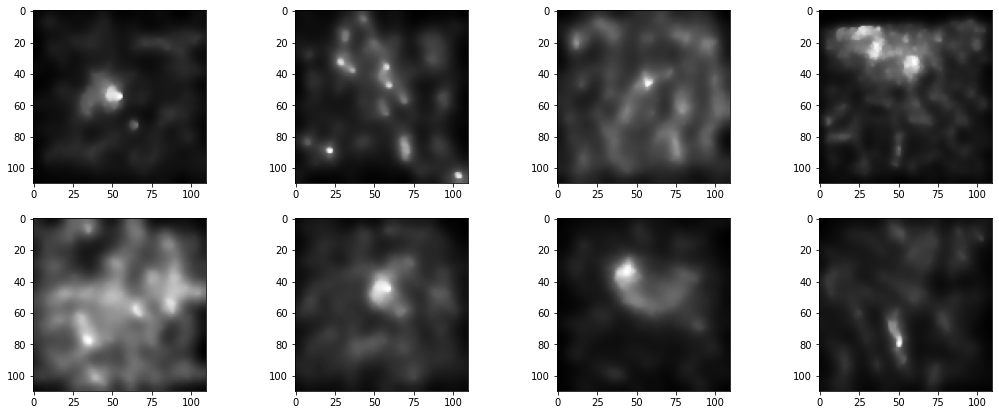

In [ ]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(18, 7)
ind = 0

for ax in axs.flat:
    img = np.array(X_denoising[ind]).reshape((110,110))
    ax.imshow(img, cmap = 'gray')
    ind += 1

### Comparando os classificadores no conjunto sem ruído

Aqui vamos usar os mesmos classificadores anteriores com os mesmos parametros configurados e analisar os resultados

In [ ]:
# Validação cruzada no classificador Naive Bayes com a métrica ROC
NB_roc = cross_val_score(NB, X_denoising, y_train['Volcano?'], cv = 5,
                scoring = make_scorer(roc_auc_score, greater_is_better = True, needs_proba = True)).mean()

# Validação cruzada no classificador LDA com a métrica ROC
LDA_roc = cross_val_score(LDA, X_denoising, y_train['Volcano?'], cv = 5,
                scoring = make_scorer(roc_auc_score, greater_is_better = True, needs_proba = True)).mean()

# Validação cruzada no classificador QDA com a métrica ROC
QDA_roc = cross_val_score(QDA, X_denoising, y_train['Volcano?'], cv = 5,
                scoring = make_scorer(roc_auc_score, greater_is_better = True, needs_proba = True)).mean()

In [ ]:
# Validação cruzada no classificador Naive Bayes com a métrica F1
NB_f1 = cross_val_score(NB, X_denoising, y_train['Volcano?'], cv = 5,
                scoring = make_scorer(f1_score, greater_is_better = True, needs_proba = False)).mean()

# Validação cruzada no classificador LDA com a métrica F1
LDA_f1 = cross_val_score(LDA, X_denoising, y_train['Volcano?'], cv = 5,
                scoring = make_scorer(f1_score, greater_is_better = True, needs_proba = False)).mean()

# Validação cruzada no classificador QDA com a métrica F1
QDA_f1 = cross_val_score(QDA, X_denoising, y_train['Volcano?'], cv = 5,
                scoring = make_scorer(f1_score, greater_is_better = True, needs_proba = False)).mean()

In [ ]:
print(f"CV nos classificadores gaussianos (denoising)\n\nNB: roc {NB_roc} f1 {NB_f1}\nLDA: roc {LDA_roc} f1 {LDA_f1}\nQDA: roc {QDA_roc} f1 {LDA_f1}")

CV nos classificadores gaussianos (denoising)

NB: roc 0.8232954166666667 f1 0.5780486911972654
LDA: roc 0.8284570833333333 f1 0.5973774735042598
QDA: roc 0.7433333333333334 f1 0.5973774735042598


### Resultados do CV nos classificadores gaussianos (usando o conjunto sem ruído)

Obtivemos os seguintes resultados para as métricas

- NB: roc 0.82 f1 0.58
- LDA: roc 0.83 f1 0.60
- QDA: roc 0.74 f1 0.60

Observamos que obtemos com o novo conjunto um resultados pior que o anterior. A suavização da imagem não ajudou na identificação dos vulcões e o primeiro processamento que fizemos nas imagens é mais promissor. Assim, vamos excluir o conjunto sem ruído da nossa análise.

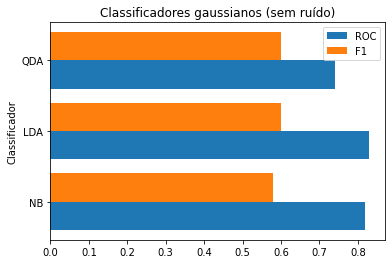

In [ ]:
X = ['NB','LDA','QDA']
roc = [0.82,0.83,0.74]
f1 = [0.58,0.60,0.60]
  
X_axis = np.arange(len(X))
  
plt.barh(X_axis - 0.2, roc, 0.4, label = 'ROC')
plt.barh(X_axis + 0.2, f1, 0.4, label = 'F1')
  
plt.yticks(X_axis, X)
plt.ylabel("Classificador")
plt.title("Classificadores gaussianos (sem ruído)")
plt.legend()
plt.show()

### Validação cruzada do classificador SVM com kernel linear

Agora vamos aos classificadores SVM, que são mais difíceis de rodar, pois são computacionalmente mais exigentes. Assim, não foi possível testar para os dois conjuntos processados e nem para muitas combinações de parâmetros.

- Começamos com o SVC de kernel linear, onde vamos fazer uma busca entre os classificadores desse tipo utilizando apenas 3 valores para o parâmetro de regularização (C)
- Usamos a validação cruzada com 5 dobras, totalizando 15 ajustes do modelo
- Definiremos o melhor valor para C (mais promissor) e aproveitamos ele nos próximos classificadores para economizar tempo de processamento
- O resultado nos dá o mesmo desempenho, usando a acurácia, para qualquer valor de C, assim, vamos usar C=1 que é padrão do SciKit Learn nas próximas validações

In [ ]:
param_linear = [{'C': [0.1, 1, 10]}] # Parâmetros de busca 
svm_linear_CV = GridSearchCV(SVC(kernel = 'linear'), param_grid = param_linear, cv = 5, scoring = 'accuracy', verbose = 4, n_jobs = -1) # Validação cruzada
svm_linear_CV.fit(X_train, y_train['Volcano?']) # Ajuste dos modelos

In [ ]:
pd.DataFrame(svm_linear_CV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,193.407941,3.925874,43.462613,0.671578,0.1,{'C': 0.1},0.925212,0.913083,0.909712,0.919042,0.913458,0.916102,0.005451,1
1,193.025429,2.422137,43.872070,1.600289,1,{'C': 1},0.925212,0.913083,0.909712,0.919042,0.913458,0.916102,0.005451,1
2,178.044079,34.018663,40.596557,9.315941,10,{'C': 10},0.925212,0.913083,0.909712,0.919042,0.913458,0.916102,0.005451,1


In [ ]:
svm_linear_CV.best_estimator_ # Melhor estimador encontrado

SVC(C=0.1, kernel='linear')

### Validação cruzada do classificador SVM com kernel RBF

- Começamos com o SVC de kernel RBF, onde vamos fazer uma busca entre os classificadores desse tipo utilizando 3 valores para o parâmetro gamma
- Usamos a validação cruzada com 5 dobras, totalizando 15 ajustes do modelo
- Definiremos o melhor valor para gamma (mais promissor) e aproveitamos ele no próximo classificador para economizar tempo de processamento
- O resultado nos dá o mesmo desempenho, usando a acurácia, para qualquer valor de gamma, assim, vamos usar gamma=1 que é padrão do SciKit Learn nas próximas validações

In [ ]:
param_rbf = [{'gamma': [0.1, 1, 10]}] # Parâmetros de busca 
svm_rbf_CV = GridSearchCV(SVC(kernel = 'rbf'), param_grid = param_rbf, cv = 5, scoring = 'accuracy', verbose = 4, n_jobs = -1) # Validação cruzada
svm_rbf_CV.fit(X_train, y_train['Volcano?']) # Ajuste dos modelos

In [ ]:
pd.DataFrame(svm_rbf_CV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,354.755655,1.143702,127.158151,1.120766,0.1,{'gamma': 0.1},0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.0,1
1,356.491916,2.805883,129.505672,2.584556,1,{'gamma': 1},0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.0,1
2,326.415261,52.956547,122.978460,17.023831,10,{'gamma': 10},0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.0,1


In [ ]:
svm_rbf_CV.best_estimator_ # Melhor estimador encontrado

SVC(gamma=0.1)

### Validação cruzada do classificador SVM com kernel polinomial

- Começamos com o SVC de kernel polinomial, onde vamos fazer uma busca entre os classificadores desse tipo utilizando 3 valores para o grau do polinômio usado
- Usamos a validação cruzada com 5 dobras, totalizando 15 ajustes do modelo
- Obtemos o polinômio de grau 2 como o mais promissor, usando a acurácia dos modelos treinados

In [ ]:
param_poly = [{'degree': [2, 3, 4]}] # Parâmetros de busca
svm_poly_CV = GridSearchCV(SVC_poly, param_grid = param_poly, cv = 5, scoring = 'accuracy', verbose = 4, n_jobs = -1) # Validação cruzada
svm_poly_CV.fit(X_train, y_train['Volcano?']) # Ajuste dos modelos

In [ ]:
pd.DataFrame(svm_poly_CV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,191.410125,2.191766,41.614217,0.912821,2,{'degree': 2},0.927857,0.918571,0.926429,0.925714,0.926429,0.925000,0.003289,1
1,182.620448,1.418669,40.703995,1.091295,3,{'degree': 3},0.925000,0.912857,0.928571,0.924286,0.925000,0.923143,0.005357,3
2,158.952731,31.746039,34.976480,7.468914,4,{'degree': 4},0.926429,0.918571,0.930714,0.921429,0.920000,0.923429,0.004504,2


In [ ]:
svm_poly_CV.best_estimator_ # Melhor estimador encontrado

SVC(degree=2, kernel='poly')

### Comparando os melhores classificadores

Vamos comparar os melhores classificadores das validações cruzadas anteriores.
- Ajustamos os melhores modelos nos conjuntos de teste
- Comparamos as métricas resultantes de cada um para decidir o melhor dos classificadores
- Os classificadores candidatos são o gaussiano LDA, e os SVM Linear (C=1), RBF (C=1, gamma=1) e polinomial (degree=2, C=1, gamma=1) 

In [12]:
clf_lda = LDA # Define o LDA
clf_lda.fit(X_train, y_train['Volcano?']) # Ajusta o LDA aos dados
y_test_pred_lda = clf_lda.predict(X_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


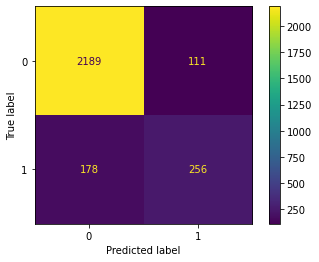

In [13]:
# Matriz de confusão resultante do classificador LDA
plot_confusion_matrix(clf_lda, X_test, y_test['Volcano?'])

In [14]:
# Métricas resultantes do classificador LDA
print(classification_report(y_test['Volcano?'], y_test_pred_lda))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2300
           1       0.70      0.59      0.64       434

    accuracy                           0.89      2734
   macro avg       0.81      0.77      0.79      2734
weighted avg       0.89      0.89      0.89      2734



In [15]:
clf_svc_lin = SVC(kernel='linear') # Define o SVM Linear
clf_svc_lin.fit(X_train, y_train['Volcano?']) # Ajusta o SVM Linear aos dados
y_test_pred_svc_lin = clf_svc_lin.predict(X_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


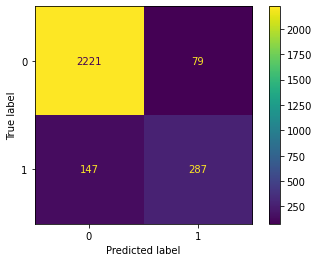

In [16]:
# Matriz de confusão resultante do classificador SVM Linear
plot_confusion_matrix(clf_svc_lin, X_test, y_test['Volcano?'])

In [17]:
# Métricas resultantes do classificador SVM Linear
print(classification_report(y_test['Volcano?'], y_test_pred_svc_lin))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2300
           1       0.78      0.66      0.72       434

    accuracy                           0.92      2734
   macro avg       0.86      0.81      0.83      2734
weighted avg       0.91      0.92      0.91      2734



In [18]:
clf_svc_rbf = SVC(kernel='rbf') # Define o SVM RBF
clf_svc_rbf.fit(X_train, y_train['Volcano?']) # Ajusta o SVM RBF aos dados
y_test_pred_svc_rbf = clf_svc_rbf.predict(X_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


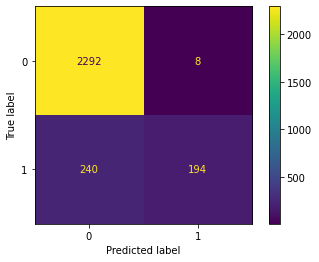

In [19]:
# Matriz de confusão resultante do classificador SVM RBF
plot_confusion_matrix(clf_svc_rbf, X_test, y_test['Volcano?'])

In [20]:
# Métricas resultantes do classificador SVM RBF
print(classification_report(y_test['Volcano?'], y_test_pred_svc_rbf))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2300
           1       0.96      0.45      0.61       434

    accuracy                           0.91      2734
   macro avg       0.93      0.72      0.78      2734
weighted avg       0.91      0.91      0.89      2734



In [22]:
clf_svc_poly = SVC(degree=2, kernel='poly') # Define o SVM Polinomial
clf_svc_poly.fit(X_train, y_train['Volcano?']) # Ajusta o SVM polinomial aos dados
y_test_pred_svc_poly = clf_svc_poly.predict(X_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


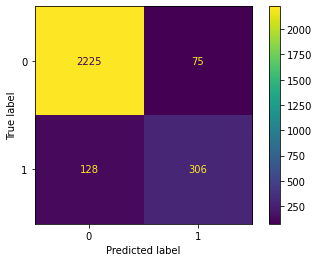

In [23]:
# Matriz de confusão resultante do classificador SVM Polinomial
plot_confusion_matrix(clf_svc_poly, X_test, y_test['Volcano?'])

In [24]:
# Métricas resultantes do classificador SVM Polinomial
print(classification_report(y_test['Volcano?'], y_test_pred_svc_poly))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2300
           1       0.80      0.71      0.75       434

    accuracy                           0.93      2734
   macro avg       0.87      0.84      0.85      2734
weighted avg       0.92      0.93      0.92      2734



### Conclusão do problema de detecção de vulcões

Agora que temos os resultados dos treinamentos dos melhores classificadores encontrados nas validações cruzadas. Vamos compará-los para decidir o melhor.

- Todos os classificadores obtiveram bons resultados, com pouca diferença entre eles
- Avaliando as métricas resultantes de cada classificador, vemos que os valores de acurácia estão próximos (entre 89% e 93%)
- Olhando para os valores de F1, vemos que o classificador SVM RBF obteve os maiores valores, assim como na métrica ROC
- Apesar de o classificador SVM RBF ter melhores números das métricas calculadas, vemos uma grande quantidade de falsos negativos, comparado aos demais
- Neste problema devemos tomar mais cuidado com a quantidade de falsos negativos, já que são poucas imagens que de fato possuem um vulcão, e "perder" uma delas é mais grave do que contar vulcões dentre as que não possuem
- **Logo, concluímos que o classificador que melhor desempenhou no problema de detecção de vulcões foi o SVM Polinomial de grau 2 com parâmetros padrões do SciKit Learn (C=1, gamma=1), já que retorna menos falsos negativos que os demais**

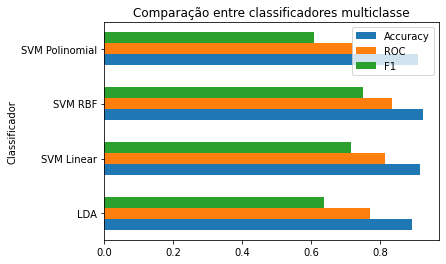

In [41]:
X = ['LDA','SVM Linear','SVM RBF','SVM Polinomial']

accuracy = [accuracy_score(y_test['Volcano?'], y_test_pred_lda),
            accuracy_score(y_test['Volcano?'], y_test_pred_svc_lin),
            accuracy_score(y_test['Volcano?'], y_test_pred_svc_poly),
            accuracy_score(y_test['Volcano?'], y_test_pred_svc_rbf)]
roc = [roc_auc_score(y_test['Volcano?'], y_test_pred_lda),
       roc_auc_score(y_test['Volcano?'], y_test_pred_svc_lin),
       roc_auc_score(y_test['Volcano?'], y_test_pred_svc_poly),
       roc_auc_score(y_test['Volcano?'], y_test_pred_svc_rbf)]
f1 = [f1_score(y_test['Volcano?'], y_test_pred_lda),
      f1_score(y_test['Volcano?'], y_test_pred_svc_lin),
      f1_score(y_test['Volcano?'], y_test_pred_svc_poly),
      f1_score(y_test['Volcano?'], y_test_pred_svc_rbf)]
  
X_axis = np.arange(len(X))
  
plt.barh(X_axis - 0.2, accuracy, 0.2, label = 'Accuracy')
plt.barh(X_axis, roc, 0.2, label = 'ROC')
plt.barh(X_axis + 0.2, f1, 0.2, label = 'F1')
  
plt.yticks(X_axis, X)
plt.ylabel("Classificador")
plt.title("Comparação entre classificadores multiclasse")
plt.legend()
plt.show()

## Problema do tipo do vulcão

### Classificando o tipo do vulcão

Agora vamos começar o problema de classificação multiclasse para o tipo do vulcão

- Primeiro vamos separar em novos conjuntos de imagens apenas aquelas em que existem um vulcão, para que possamos trabalhar o problema multiclasse para classificar o tipo
- Os possíveis valores são: 1 (certamente tem vulcão), 2 (provavelmente tem vulcão), 3 (possivelmente tem vulcão) ou 4 (pouco provável de ter vulcão)

In [ ]:
X_is_volcano_train = X_peaks[y_train['Volcano?']==1]
y_is_volcano_train = y_train[y_train['Volcano?']==1]
X_is_volcano_test = X_peaks_test[y_test['Volcano?']==1]
y_is_volcano_test = y_test[y_test['Volcano?']==1]

In [ ]:
y_is_volcano_train.head()

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
9,1,1.0,22.02,1.0
15,1,1.0,14.76,1.0
29,1,4.0,6.40,1.0
34,1,3.0,21.63,2.0


### Testando o classificador Naive Bayes

Vamos usar as duas estratégias OvO e OvR no classificador Naive Bayes e comparar os resultados

In [ ]:
ovo_clf_nb = OneVsOneClassifier(NB, n_jobs = -1) # Define o OvO
ovo_clf_nb.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovo_nb = ovo_clf_nb.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


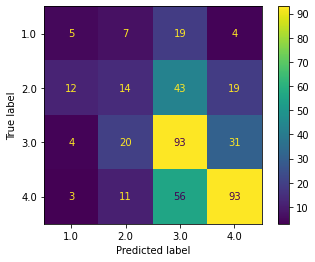

In [ ]:
# Matriz de confusão resultante do OvO no classificador Naive Bayes
plot_confusion_matrix(ovo_clf_nb, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvO no classificador Naive Bayes
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovo_nb))

              precision    recall  f1-score   support

         1.0       0.21      0.14      0.17        35
         2.0       0.27      0.16      0.20        88
         3.0       0.44      0.63      0.52       148
         4.0       0.63      0.57      0.60       163

    accuracy                           0.47       434
   macro avg       0.39      0.38      0.37       434
weighted avg       0.46      0.47      0.46       434



In [ ]:
ovr_clf_nb = OneVsRestClassifier(NB, n_jobs = -1) # Define o OvR
ovr_clf_nb.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovr_nb = ovr_clf_nb.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


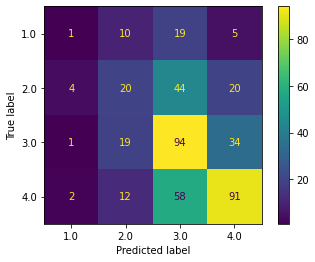

In [ ]:
# Matriz de confusão resultante do OvR no classificador Naive Bayes
plot_confusion_matrix(ovr_clf_nb, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvR no classificador Naive Bayes
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovr_nb))

              precision    recall  f1-score   support

         1.0       0.12      0.03      0.05        35
         2.0       0.33      0.23      0.27        88
         3.0       0.44      0.64      0.52       148
         4.0       0.61      0.56      0.58       163

    accuracy                           0.47       434
   macro avg       0.37      0.36      0.35       434
weighted avg       0.45      0.47      0.45       434



### Resultados do Naive Bayes na classificação multiclasse

- Usando OvO obtemos 47% de acurácia e f1-score entre 0.17 e 0.6 para cada classe
- Usando OvR obtemos 47% de acurácia e f1-score entre 0.05 e 0.58 para cada classe
- Os resultados foram muito próximos, logo concluímos que os classificadores possuem praticamente o mesmo desempenho

### Testando o classificador LDA

Vamos usar as duas estratégias OvO e OvR no classificador LDA e comparar os resultados

In [ ]:
ovo_clf_lda = OneVsOneClassifier(LDA, n_jobs = -1) # Define o OvO
ovo_clf_lda.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovo_lda = ovo_clf_lda.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


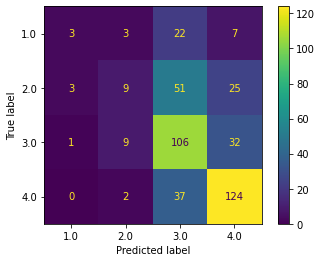

In [ ]:
# Matriz de confusão resultante do OvO no classificador LDA
plot_confusion_matrix(ovo_clf_lda, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvO no classificador LDA
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovo_lda))

              precision    recall  f1-score   support

         1.0       0.43      0.09      0.14        35
         2.0       0.39      0.10      0.16        88
         3.0       0.49      0.72      0.58       148
         4.0       0.66      0.76      0.71       163

    accuracy                           0.56       434
   macro avg       0.49      0.42      0.40       434
weighted avg       0.53      0.56      0.51       434



In [ ]:
ovr_clf_lda = OneVsRestClassifier(LDA, n_jobs = -1) # Define o OvR
ovr_clf_lda.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovr_lda = ovr_clf_lda.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


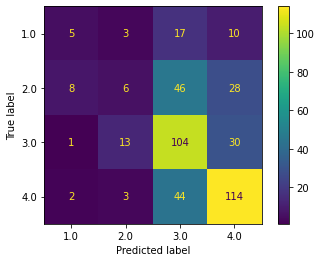

In [ ]:
# Matriz de confusão resultante do OvR no classificador LDA
plot_confusion_matrix(ovr_clf_lda, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvR no classificador LDA
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovr_lda))

              precision    recall  f1-score   support

         1.0       0.31      0.14      0.20        35
         2.0       0.24      0.07      0.11        88
         3.0       0.49      0.70      0.58       148
         4.0       0.63      0.70      0.66       163

    accuracy                           0.53       434
   macro avg       0.42      0.40      0.39       434
weighted avg       0.48      0.53      0.48       434



### Resultados do LDA na classificação multiclasse

- Usando OvO obtemos 56% de acurácia e f1-score entre 0.14 e 0.71 para cada classe
- Usando OvR obtemos 53% de acurácia e f1-score entre 0.20 e 0.66 para cada classe
- Os resultados foram parecidos, mas o método OvO levou vantagem, com acurácia maior e os valores de F1 passando de 0.7

### Testando o classificador QDA

Vamos usar as duas estratégias OvO e OvR no classificador QDA e comparar os resultados

In [ ]:
ovo_clf_qda = OneVsOneClassifier(QDA, n_jobs = -1) # Define o OvO
ovo_clf_qda.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovo_qda = ovo_clf_qda.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


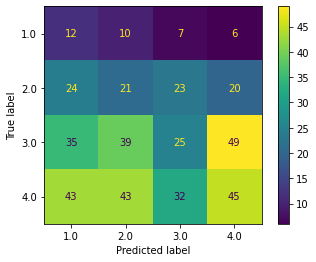

In [ ]:
# Matriz de confusão resultante do OvO no classificador QDA
plot_confusion_matrix(ovo_clf_qda, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvO no classificador LDA
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovo_qda))

              precision    recall  f1-score   support

         1.0       0.11      0.34      0.16        35
         2.0       0.19      0.24      0.21        88
         3.0       0.29      0.17      0.21       148
         4.0       0.38      0.28      0.32       163

    accuracy                           0.24       434
   macro avg       0.24      0.26      0.23       434
weighted avg       0.29      0.24      0.25       434



In [ ]:
ovr_clf_qda = OneVsRestClassifier(QDA, n_jobs = -1) # Define o OvR
ovr_clf_qda.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovr_qda = ovr_clf_qda.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


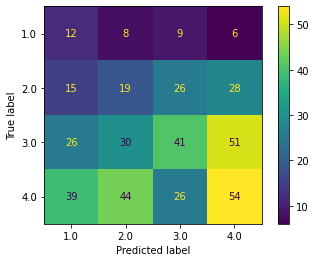

In [ ]:
# Matriz de confusão resultante do OvR no classificador LDA
plot_confusion_matrix(ovr_clf_qda, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvR no classificador LDA
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovr_qda))

              precision    recall  f1-score   support

         1.0       0.13      0.34      0.19        35
         2.0       0.19      0.22      0.20        88
         3.0       0.40      0.28      0.33       148
         4.0       0.39      0.33      0.36       163

    accuracy                           0.29       434
   macro avg       0.28      0.29      0.27       434
weighted avg       0.33      0.29      0.30       434



### Resultados do QDA na classificação multiclasse

- Usando OvO obtemos 24% de acurácia e f1-score entre 0.16 e 0.32 para cada classe
- Usando OvR obtemos 29% de acurácia e f1-score entre 0.19 e 0.36 para cada classe
- Os resultados fmostram uma baixa acurácia e valores de F1 baixos, logo concluímos que os classificadores possuem desempenho ruim, mas com o método OvR levando pequena vantagem

### Testando o classificador SVM com kernel linear

Vamos usar as duas estratégias OvO e OvR no classificador SVM com kernel linear e comparar os resultados. 
Usaremos os parâmetros padrões do SciKit Learn para não precisar fazer testes exaustivos com várias combinações de parâmetros.
- No caso do SVC de kernel linear usamos a classe LinearSVC do SciKit Learn que é implementado de forma diferente do SVC(kernel="linear") e funciona melhor para o caso de classificação multiclasse

In [ ]:
ovo_clf_svc_lin = OneVsOneClassifier(LinearSVC(), n_jobs = -1) # Define o OvO
ovo_clf_svc_lin.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovo_svc_lin = ovo_clf_svc_lin.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


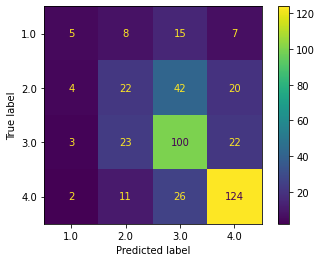

In [ ]:
# Matriz de confusão resultante do OvO no classificador SVM linear
plot_confusion_matrix(ovo_clf_svc_lin, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvO no classificador SVM linear
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovo_svc_lin))

              precision    recall  f1-score   support

         1.0       0.36      0.14      0.20        35
         2.0       0.34      0.25      0.29        88
         3.0       0.55      0.68      0.60       148
         4.0       0.72      0.76      0.74       163

    accuracy                           0.58       434
   macro avg       0.49      0.46      0.46       434
weighted avg       0.55      0.58      0.56       434



In [ ]:
ovr_clf_svc_lin = OneVsRestClassifier(LinearSVC(), n_jobs = -1) # Define o OvR
ovr_clf_svc_lin.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovr_svc_lin = ovr_clf_svc_lin.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


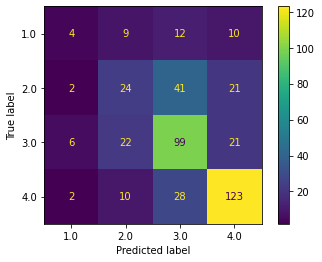

In [ ]:
# Matriz de confusão resultante do OvR no classificador SVM linear
plot_confusion_matrix(ovr_clf_svc_lin, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvR no classificador SVM linear
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovr_svc_lin))

              precision    recall  f1-score   support

         1.0       0.29      0.11      0.16        35
         2.0       0.37      0.27      0.31        88
         3.0       0.55      0.67      0.60       148
         4.0       0.70      0.75      0.73       163

    accuracy                           0.58       434
   macro avg       0.48      0.45      0.45       434
weighted avg       0.55      0.58      0.56       434



### Resultados do SVM Linear na classificação multiclasse

- Usando OvO obtemos 58% de acurácia e f1-score entre 0.2 e 0.74 para cada classe
- Usando OvR obtemos 58% de acurácia e f1-score entre 0.16 e 0.73 para cada classe
- Os resultados foram muito próximos, mas ambos são melhores que os encontrados com os classificadores gaussianos

### Testando o classificador SVM com kernel polinomial (grau 2)

Vamos usar as duas estratégias OvO e OvR no classificador SVM com kernel polinomial (grau 2) e comparar os resultados.
Usaremos os parâmetros padrões do SciKit learning para não precisar fazer testes exaustivos com várias combinações de parâmetros

In [ ]:
ovo_clf_svc_p2 = OneVsOneClassifier(SVC(kernel='poly', degree=2), n_jobs = -1) # Define o OvO
ovo_clf_svc_p2.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovo_svc_p2 = ovo_clf_svc_p2.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


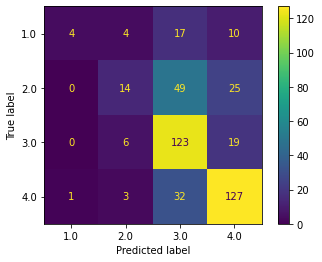

In [ ]:
# Matriz de confusão resultante do OvO no classificador SVM polinomial de grau 2
plot_confusion_matrix(ovo_clf_svc_p2, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvO no classificador SVM polinomial de grau 2
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovo_svc_p2))

              precision    recall  f1-score   support

         1.0       0.80      0.11      0.20        35
         2.0       0.52      0.16      0.24        88
         3.0       0.56      0.83      0.67       148
         4.0       0.70      0.78      0.74       163

    accuracy                           0.62       434
   macro avg       0.64      0.47      0.46       434
weighted avg       0.62      0.62      0.57       434



In [ ]:
ovr_clf_svc_p2 = OneVsRestClassifier(SVC(kernel='poly', degree=2), n_jobs = -1) # Define o OvR
ovr_clf_svc_p2.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovr_svc_p2 = ovr_clf_svc_p2.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


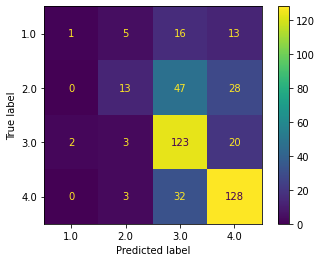

In [ ]:
# Matriz de confusão resultante do OvR no classificador SVM polinomial de grau 2
plot_confusion_matrix(ovr_clf_svc_p2, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvR no classificador SVM polinomial de grau 2 
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovr_svc_p2))

              precision    recall  f1-score   support

         1.0       0.33      0.03      0.05        35
         2.0       0.54      0.15      0.23        88
         3.0       0.56      0.83      0.67       148
         4.0       0.68      0.79      0.73       163

    accuracy                           0.61       434
   macro avg       0.53      0.45      0.42       434
weighted avg       0.58      0.61      0.55       434



### Resultados do SVM Polinomial de grau 2 na classificação multiclasse

- Usando OvO obtemos 62% de acurácia e f1-score entre 0.2 e 0.74 para cada classe
- Usando OvR obtemos 61% de acurácia e f1-score entre 0.05 e 0.73 para cada classe
- Os resultados foram parecidos, mas ambos são melhores que o classificado SVM linear. A acurácia passa dos 60% e os valores de F1 passam de 0.7

### Testando o classificador SVM com kernel polinomial (grau 3)

Vamos usar as duas estratégias OvO e OvR no classificador SVM com kernel polinomial (grau 3) e comparar os resultados.
Usaremos os parâmetros padrões do SciKit learning para não precisar fazer testes exaustivos com várias combinações de parâmetros

In [ ]:
ovo_clf_svc_p3 = OneVsOneClassifier(SVC(kernel='poly', degree=3), n_jobs = -1) # Define o OvO
ovo_clf_svc_p3.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovo_svc_p3 = ovo_clf_svc_p3.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


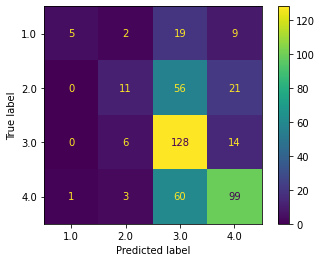

In [ ]:
# Matriz de confusão resultante do OvO no classificador SVM polinomial de grau 3
plot_confusion_matrix(ovo_clf_svc_p3, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvO no classificador SVM polinomial de grau 3
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovo_svc_p3))

              precision    recall  f1-score   support

         1.0       0.83      0.14      0.24        35
         2.0       0.50      0.12      0.20        88
         3.0       0.49      0.86      0.62       148
         4.0       0.69      0.61      0.65       163

    accuracy                           0.56       434
   macro avg       0.63      0.44      0.43       434
weighted avg       0.59      0.56      0.52       434



In [ ]:
ovr_clf_svc_p3 = OneVsRestClassifier(SVC(kernel='poly', degree=3), n_jobs = -1) # Define o OvR
ovr_clf_svc_p3.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovr_svc_p3 = ovr_clf_svc_p3.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


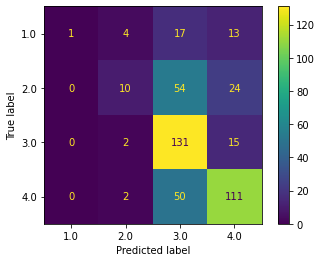

In [ ]:
# Matriz de confusão resultante do OvR no classificador SVM polinomial de grau 3
plot_confusion_matrix(ovr_clf_svc_p3, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvR no classificador SVM polinomial de grau 3 
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovr_svc_p3))

              precision    recall  f1-score   support

         1.0       1.00      0.03      0.06        35
         2.0       0.56      0.11      0.19        88
         3.0       0.52      0.89      0.66       148
         4.0       0.68      0.68      0.68       163

    accuracy                           0.58       434
   macro avg       0.69      0.43      0.40       434
weighted avg       0.63      0.58      0.52       434



### Resultados do SVM Polinomial de grau 3 na classificação multiclasse

- Usando OvO obtemos 56% de acurácia e f1-score entre 0.24 e 0.65 para cada classe
- Usando OvR obtemos 58% de acurácia e f1-score entre 0.06 e 0.68 para cada classe
- Os resultados foram parecidos, com leve vantagem para o OvR, mas ambos pioraram com relação ao classificador de grau 2

### Testando o classificador SVM com kernel polinomial (grau 4)

Vamos usar as duas estratégias OvO e OvR no classificador SVM com kernel polinomial (grau 4) e comparar os resultados.
Usaremos os parâmetros padrões do SciKit learning para não precisar fazer testes exaustivos com várias combinações de parâmetros

In [ ]:
ovo_clf_svc_p4 = OneVsOneClassifier(SVC(kernel='poly', degree=4), n_jobs = -1) # Define o OvO
ovo_clf_svc_p4.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovo_svc_p4 = ovo_clf_svc_p4.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


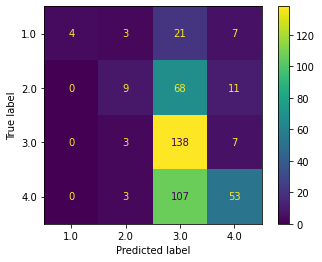

In [ ]:
# Matriz de confusão resultante do OvO no classificador SVM polinomial de grau 4
plot_confusion_matrix(ovo_clf_svc_p4, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvO no classificador SVM polinomial de grau 4
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovo_svc_p4))

              precision    recall  f1-score   support

         1.0       1.00      0.11      0.21        35
         2.0       0.50      0.10      0.17        88
         3.0       0.41      0.93      0.57       148
         4.0       0.68      0.33      0.44       163

    accuracy                           0.47       434
   macro avg       0.65      0.37      0.35       434
weighted avg       0.58      0.47      0.41       434



In [ ]:
ovr_clf_svc_p4 = OneVsRestClassifier(SVC(kernel='poly', degree=4), n_jobs = -1) # Define o OvR
ovr_clf_svc_p4.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovr_svc_p4 = ovr_clf_svc_p4.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


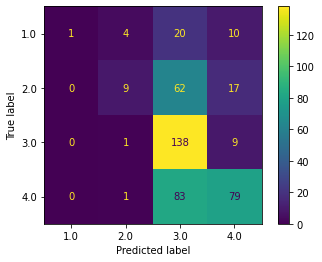

In [ ]:
# Matriz de confusão resultante do OvR no classificador SVM polinomial de grau 4
plot_confusion_matrix(ovr_clf_svc_p4, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvR no classificador SVM polinomial de grau 4 
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovr_svc_p4))

              precision    recall  f1-score   support

         1.0       1.00      0.03      0.06        35
         2.0       0.60      0.10      0.17        88
         3.0       0.46      0.93      0.61       148
         4.0       0.69      0.48      0.57       163

    accuracy                           0.52       434
   macro avg       0.69      0.39      0.35       434
weighted avg       0.62      0.52      0.46       434



### Resultados do SVM Polinomial de grau 4 na classificação multiclasse

- Usando OvO obtemos 47% de acurácia e f1-score entre 0.21 e 0.47 para cada classe
- Usando OvR obtemos 52% de acurácia e f1-score entre 0.06 e 0.57 para cada classe
- Os resultados pioraram com relação aos SVM polinomiais anteriores, logo conclímos que usar grau 2 é mais promissor do que graus maiores

### Testando o classificador SVM com kernel RBF

Vamos usar as duas estratégias OvO e OvR no classificador SVM com kernel RBF e comparar os resultados.
Usaremos os parâmetros padrões do SciKit learning para não precisar fazer testes exaustivos com várias combinações de parâmetros

In [ ]:
ovo_clf_svc_rbf = OneVsOneClassifier(SVC_rbf, n_jobs = -1) # Define o OvO
ovo_clf_svc_rbf.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovo_svc_rbf = ovo_clf_svc_rbf.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


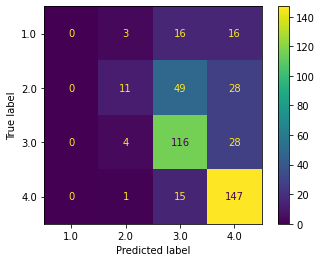

In [ ]:
# Matriz de confusão resultante do OvO no classificador SVM RBF
plot_confusion_matrix(ovo_clf_svc_rbf, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvO no classificador SVM RBF
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovo_svc_rbf))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        35
         2.0       0.58      0.12      0.21        88
         3.0       0.59      0.78      0.67       148
         4.0       0.67      0.90      0.77       163

    accuracy                           0.63       434
   macro avg       0.46      0.45      0.41       434
weighted avg       0.57      0.63      0.56       434



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
ovr_clf_svc_rbf = OneVsRestClassifier(SVC_rbf, n_jobs = -1) # Define o OvR
ovr_clf_svc_rbf.fit(X_is_volcano_train, y_is_volcano_train['Type']) # Ajusta o modelo aos dados
y_test_pred_ovr_svc_rbf = ovr_clf_svc_rbf.predict(X_is_volcano_test) # Faz a previsão no conjunto de teste

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


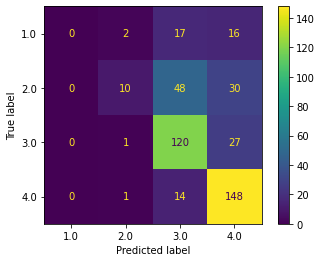

In [ ]:
# Matriz de confusão resultante do OvR no classificador SVM RBF
plot_confusion_matrix(ovr_clf_svc_rbf, X_is_volcano_test, y_is_volcano_test['Type'])

In [ ]:
# Métricas resultantes do OvR no classificador SVM RBF
print(classification_report(y_is_volcano_test['Type'], y_test_pred_ovr_svc_rbf))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        35
         2.0       0.71      0.11      0.20        88
         3.0       0.60      0.81      0.69       148
         4.0       0.67      0.91      0.77       163

    accuracy                           0.64       434
   macro avg       0.50      0.46      0.41       434
weighted avg       0.60      0.64      0.57       434



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Resultados do SVM RBF na classificação multiclasse

- Usando OvO obtemos 63% de acurácia e f1-score entre 0 e 0.77 para cada classe
- Usando OvR obtemos 64% de acurácia e f1-score entre 0 e 0.77 para cada classe
- Os resultados foram os melhores usando o kernel RBF. A acurácia passa de 60% e os F1 chegam a 0.77 no OvO e no OvR

### Conclusão do problema de classificação do tipo do vulcão

Por fim, vamos comparar os resultados dos classificadores que testamos.

- Usaremos a acurácia para escolher o melhor classificador, o que mais acerta, em média, o tipo de um vulcão
- Plotamos um gráfico para comparar as estratégias OvO e OvR em cada classificador
- **O melhor classificador testado é o SVM com kernel RBF, usando o método OvR**

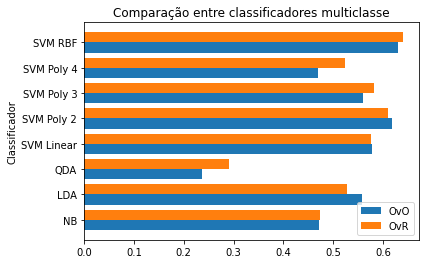

In [ ]:
X = ['NB','LDA','QDA', 'SVM Linear', 'SVM Poly 2', 'SVM Poly 3', 'SVM Poly 4', 'SVM RBF']

ovo = [accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovo_nb),
       accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovo_lda),
       accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovo_qda),
       accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovo_svc_lin),
       accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovo_svc_p2),
       accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovo_svc_p3),
       accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovo_svc_p4),
       accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovo_svc_rbf)]
ovr = [accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovr_nb),
      accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovr_lda),
      accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovr_qda),
      accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovr_svc_lin),
      accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovr_svc_p2),
      accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovr_svc_p3),
      accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovr_svc_p4),
      accuracy_score(y_is_volcano_test['Type'], y_test_pred_ovr_svc_rbf)]
  
X_axis = np.arange(len(X))
  
plt.barh(X_axis - 0.2, ovo, 0.4, label = 'OvO')
plt.barh(X_axis + 0.2, ovr, 0.4, label = 'OvR')
  
plt.yticks(X_axis, X)
plt.ylabel("Classificador")
plt.title("Comparação entre classificadores multiclasse")
plt.legend()
plt.show()

- O melhor classificador nos testes foi o SVM com kernel RBF no OvR com resultados próximos ao de kernel polinomial de grau 2 no OvO
- O pior classificador é o gaussiano QDA, que performa muito abaixo dos demais, principalmente usando OvO